# Env v2
Implement everything with just convolutions on batches of worlds

In [1]:
import torch
import numpy as np
from torch.nn.functional import conv2d, relu
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [2]:
ORIENTATION_FILTERS = torch.Tensor([
    [
        [0, 1, 0],
        [0, -1, 0],
        [0, 0, 0],
    ],
    [
        [0, 0, 0],
        [0, -1, 1],
        [0, 0, 0],
    ],
    [
        [0, 0, 0],
        [0, -1, 0],
        [0, 1, 0],
    ],
    [
        [0, 0, 0],
        [1, -1, 0],
        [0, 0, 0],
    ],
]).unsqueeze(1).float()

In [3]:
SIZE = 12
FOOD_CHANNEL = 0
FOOD_REWARD = 1
HEAD_CHANNEL = 1
BODY_CHANNEL = 2
OPPOSITE_DIRECTION = {
    'up': 'down',
    'down': 'up',
    'left': 'right',
    'right': 'left'
}
DIRECTION_TO_CONV = {
    'up': torch.tensor([
        [0, 1, 0],
        [0, -1, 0],
        [0, 0, 0],
    ]).float().unsqueeze(0).unsqueeze(0),
    'right': torch.tensor([
        [0, 0, 0],
        [1, -1, 0],
        [0, 0, 0],
    ]).float().unsqueeze(0).unsqueeze(0),
    'down': torch.tensor([
        [0, 0, 0],
        [0, 0, 0],
        [0, 1, 0],
    ]).float().unsqueeze(0).unsqueeze(0),
    'left': torch.tensor([
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0],
    ]).float().unsqueeze(0).unsqueeze(0),
}
NO_CHANGE_CONV = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0],
]).float().unsqueeze(0).unsqueeze(0)
EMPTY_CONV = torch.tensor([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
]).float().unsqueeze(0).unsqueeze(0)

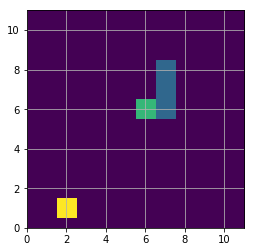

In [4]:
def get_test_world(orientation='up'):
    world  = torch.zeros((1, 3, SIZE, SIZE))
    if orientation == 'up':
        world[0, BODY_CHANNEL, 3, 3] = 1
        world[0, BODY_CHANNEL, 3, 4] = 2
        world[0, BODY_CHANNEL, 4, 4] = 3
        world[0, BODY_CHANNEL, 5, 4] = 4
        
        world[0, HEAD_CHANNEL, 5, 4] = 1

        world[0, FOOD_CHANNEL, 6, 6] = 1
    elif orientation == 'right':
        world[0, BODY_CHANNEL, 3, 3] = 1
        world[0, BODY_CHANNEL, 3, 4] = 2
        world[0, BODY_CHANNEL, 4, 4] = 3
        world[0, BODY_CHANNEL, 4, 5] = 4
        
        world[0, HEAD_CHANNEL, 4, 5] = 1

        world[0, FOOD_CHANNEL, 6, 9] = 1
    elif orientation == 'down':
        world[0, BODY_CHANNEL, 8, 8] = 1
        world[0, BODY_CHANNEL, 7, 8] = 2
        world[0, BODY_CHANNEL, 6, 8] = 3
        world[0, BODY_CHANNEL, 5, 8] = 4
        
        world[0, HEAD_CHANNEL, 5, 8] = 1

        world[0, FOOD_CHANNEL, 7, 2] = 1 
    elif orientation == 'left':
        world[0, BODY_CHANNEL, 8, 7] = 1
        world[0, BODY_CHANNEL, 7, 7] = 2
        world[0, BODY_CHANNEL, 6, 7] = 3
        world[0, BODY_CHANNEL, 6, 6] = 4
        
        world[0, HEAD_CHANNEL, 6, 6] = 1

        world[0, FOOD_CHANNEL, 1, 2] = 1 
    else:
        raise Exception
    
    return world

def plot_world(world, mode='single'):
    if mode == 'single':
        img = (world[0, BODY_CHANNEL, :, :].numpy() > 0) * 0.5
        img += world[0, HEAD_CHANNEL, :, :].numpy() * 0.5
        img += world[0, FOOD_CHANNEL, :, :].numpy() * 1.5
        plt.imshow(img, vmin=0, vmax=1.5)
        plt.xlim((0, SIZE-1))
        plt.ylim((0, SIZE-1))
        plt.grid()
    if mode == 'multi':
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for i, title in zip(range(3), ['Food','Head','Body']):
            axes[i].set_title(title)
            axes[i].imshow(world[0, i, : ,:].numpy())
            axes[i].grid()
            axes[i].set_xlim((0, SIZE-1))
            axes[i].set_ylim((0, SIZE-1))

plot_world(get_test_world('left'))

In [5]:
def determine_orientations(worlds):
    """Returns a batch of snake orientations from a batch of worlds."""
    # Generate "neck" channel where the head is +1, the next piece of the snake
    # is -1 and the rest are 0
    n = worlds.shape[0]
    bodies = worlds[:, BODY_CHANNEL:BODY_CHANNEL+1, :]
    snake_sizes = bodies.view(n, -1).max(dim=1)[0]
    snake_sizes.sub_(2)
    shift = snake_sizes[:, None, None, None].expand_as(bodies)
    necks = relu(bodies - shift)
    necks.sub_(1.5*(torch.ones_like(necks) * (necks > 0).float()))
    necks.mul_(2)
    
    # Convolve with 4 predetermined filters one of which will be more activated
    # because it lines up with the orientation of the snake
    responses = conv2d(necks, ORIENTATION_FILTERS, padding=1)
    
    # Find which filter
    responses = responses.view(n, 4, -1)
    orientations = responses.max(dim=-1)[0].argmax(dim=-1)
    
    return orientations

determine_orientations(torch.cat([
    get_test_world('up'), get_test_world('right'), get_test_world('down'), get_test_world('left')], dim=0)
)

tensor([2, 1, 0, 3])

In [6]:
def food(worlds):
    return worlds[:, FOOD_CHANNEL:FOOD_CHANNEL+1]

def head(worlds):
    return worlds[:, HEAD_CHANNEL:HEAD_CHANNEL+1]

def body(worlds):
    return worlds[:, BODY_CHANNEL:BODY_CHANNEL+1]

In [7]:
def step_worlds(worlds, actions):
    n = worlds.shape[0]
    assert n == actions.shape[0]
    
    reward = torch.zeros((n,)).long()
    done = torch.zeros((n,)).byte()
    info = [dict(), ] * n

    snake_sizes = worlds[:, BODY_CHANNEL:BODY_CHANNEL+1, :].view(n, -1).max(dim=1)[0]
    
    orientations = determine_orientations(worlds)
    
    # Check if any snakes are trying to move backwards and change
    # their direction/action to just continue forward
    # The test for this is if their orientation number {0, 1, 2, 3}
    # is the same as their action
    mask = orientations == actions
    actions.add_((mask * 2).long()).fmod_(4)

    # Create head position deltas
    head_deltas = conv2d(head(worlds), ORIENTATION_FILTERS, padding=1)
    
    # Mask the head-movement deltas with direction action
    head_deltas = torch.index_select(head_deltas, 1, actions.long())
    
    # Move head position by applying delta
    worlds[:, HEAD_CHANNEL:HEAD_CHANNEL+1, :, :].add_(head_deltas)
    
    # Check for hitting self
    hit_self = (head(worlds) * body(worlds)).view(n, -1).sum(dim=-1) > 0
    done = torch.clamp(done + hit_self, 0, 1)

    ################
    # Apply update #
    ################
    
    # Decay the body sizes by 1, hence moving the body
    body_movement = torch.zeros_like(worlds)
    body_movement[:, BODY_CHANNEL, :, :] = -1
    worlds = relu(worlds + body_movement)
    # Create a new head position in the body channel
    worlds[:, BODY_CHANNEL:BODY_CHANNEL+1, :, :] += \
        head(worlds) * snake_sizes[:, None, None, None].expand((n, 1, SIZE, SIZE))
    # Apply food growth i.e. +1 to all snake locations
    worlds[:, BODY_CHANNEL:BODY_CHANNEL+1, :, :] += \
        ((head(worlds) * food(worlds)).sum() > 0) * body(worlds).clamp(0, 1)
   
    # Remove food if neccessary
    food_removal = head(worlds) * food(worlds) * -1
    reward.sub_(food_removal.view(n, -1).sum(dim=-1).long())
    worlds[:, FOOD_CHANNEL:FOOD_CHANNEL+1, :, :] += food_removal
    # Add new food if necessary
    pass  # Add a random food location multipled by ((head * food).sum() > 0)

    # Check for boundary, Done by performing a convolution with no padding
    # If the head is at the edge then it will be cut off and the sum of the head
    # channel will be 0
    head_at_edge = conv2d(
        head(worlds),
        NO_CHANGE_CONV,
    ).view(n, -1).sum(dim=-1) == 0
    done = torch.clamp(done + head_at_edge, 0, 1)
    
    # Some asserts:
    # Only one head per snake channel
    assert torch.all(head(worlds).view(n, -1).sum(dim=-1) == 1)
    
    return worlds, reward, done, info

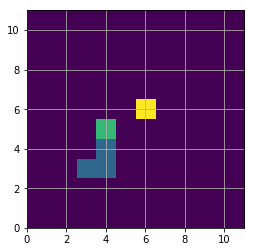

tensor([0])


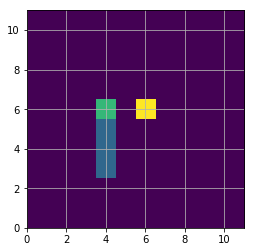

tensor([0])


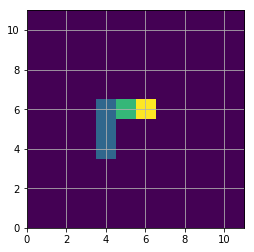

tensor([1])


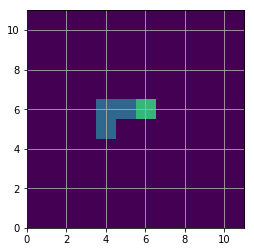

tensor([0])


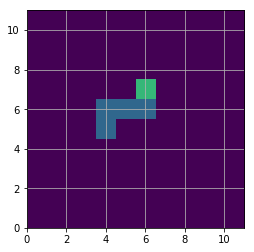

tensor([0])


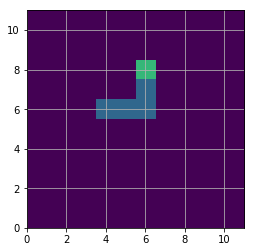

tensor([0])


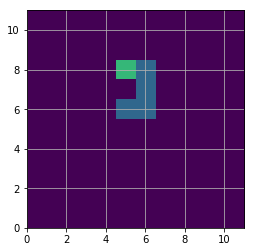

In [8]:
# Food eating test
# moves = ['up', 'right', 'right', 'up', 'up', 'left']
actions = torch.tensor([0, 3, 3, 0, 0, 1]).unsqueeze(1)

test_world = get_test_world()
for a in actions:
    plot_world(test_world, mode='single')
    plt.show()
    test_world, reward, done, info = step_worlds(test_world, a)
    print(reward)

plot_world(test_world, mode='single')
plt.show()

In [183]:
def get_random_available_location(locs):
    locations = torch.nonzero(locs)
    random_loc = locations[torch.randperm(locations.shape[0])[:1]]
    return random_loc

tensor([[0, 1, 3]])

In [195]:
test_world = torch.cat([get_test_world(), get_test_world()], dim=0)
test_world.shape

n = test_world.shape[0]
available_locations = test_world.sum(dim=1, keepdim=True) == 0
available_locations[:, :, :1, :] = 0
available_locations[:, :, :, :1] = 0
available_locations[:, :, -1:, :] = 0
available_locations[:, :, :, -1:] = 0

food_indices = torch.cat([get_random_available_location(locs) for locs in available_locations.unbind()])
food_indices = torch.cat([torch.arange(n).unsqueeze(1), food_indices], dim=1)

val = torch.ones(len(food_indices))
food_addition = torch.sparse.FloatTensor(food_indices.t(), val, available_locations.shape)
food_addition = food_addition.to_dense()
food_addition

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0

In [131]:
# food_addition = torch.zeros_like(available_locations)
# index = torch.zeros((1, 1, 12, 12)
# food_addition.scatter_(0, torch.zeros((1, 1, 12, 12)).long(), 1)

# food_addition

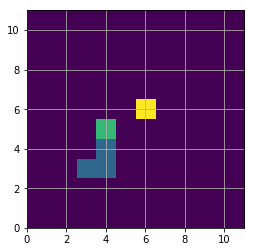

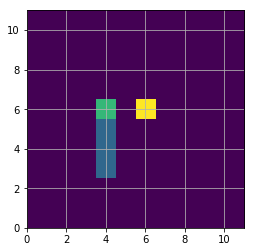

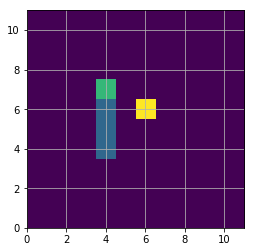

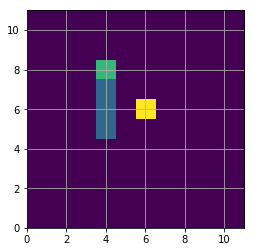

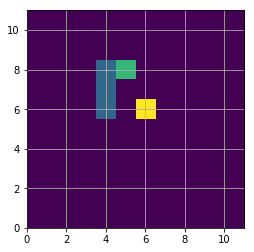

In [8]:
# Move backwards test
# moves = ['down', 'down', 'down', 'right']
actions = torch.tensor([2, 2, 2, 3]).unsqueeze(1)

test_world = get_test_world()
for m in actions:
    plot_world(test_world)
    plt.show()
    test_world, reward, done, info = step_worlds(test_world, m)
    
plot_world(test_world)
plt.show()

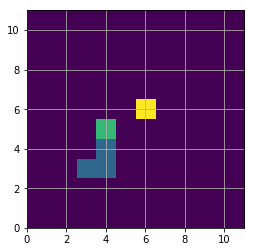

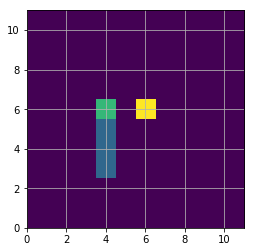

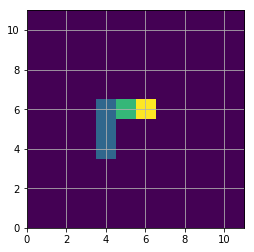

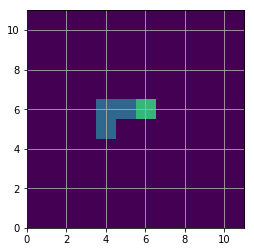

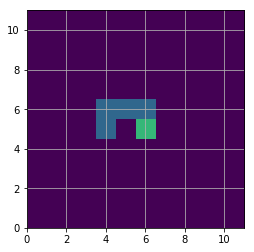

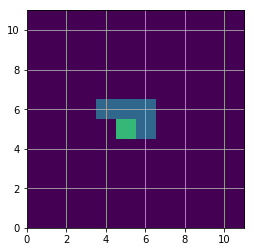

Hit self


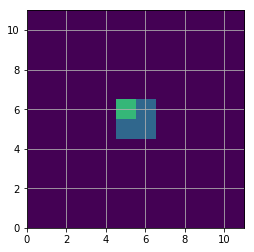

In [9]:
# Hits self test
# moves = ['up', 'right', 'right', 'down', 'left', 'up', 'up', 'up']
actions = torch.tensor([0, 3, 3, 2, 1, 0, 0, 0]).unsqueeze(1)


test_world = get_test_world()
for m in actions:
    plot_world(test_world, mode='single')
    plt.show()
    test_world, reward, done, info = step_worlds(test_world, m)
    
    if done:
        print('Hit self')
        break
    
plot_world(test_world, mode='single')
plt.show()

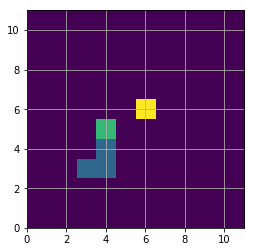

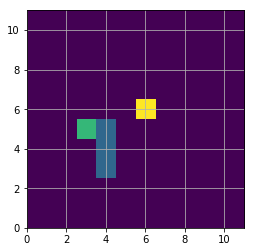

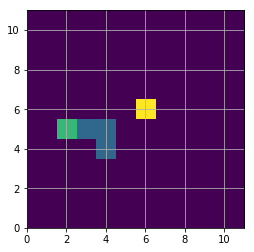

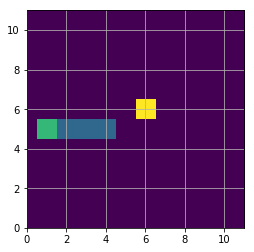

Hit boundary


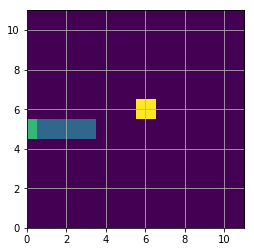

In [10]:
# Hits boundary test
# moves = ['left'] * 10
actions = torch.tensor([1, ]* 10).unsqueeze(1)

test_world = get_test_world()
for a in actions:
    plot_world(test_world)
    plt.show()
    test_world, reward, done, info = step_worlds(test_world, a)
    
    if done:
        print('Hit boundary')
        break
    
plot_world(test_world)
plt.show()

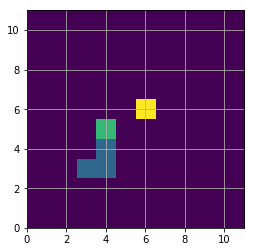

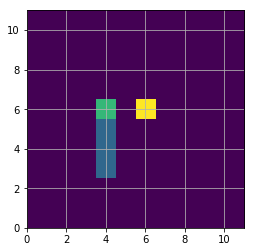

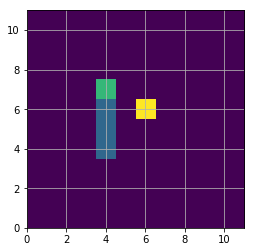

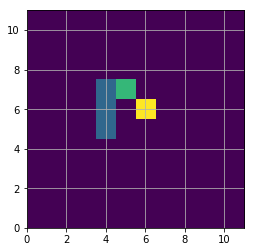

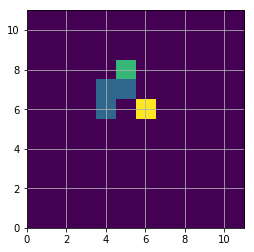

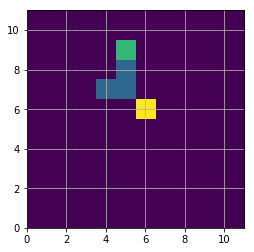

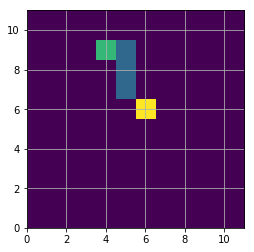

In [12]:
# Basic test
# moves = ['up', 'up', 'right', 'up', 'up', 'left']
actions = torch.tensor([0, 0, 3, 0, 0, 1]).unsqueeze(1)

test_world = get_test_world()
for a in actions:
    plot_world(test_world)
    plt.show()
    test_world, reward, done, info = step_worlds(test_world, a)
    
plot_world(test_world)
plt.show()